In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=de00dfba93f7d7f46fc0b3a536128ea805cf7e63323a89cf219fa1a86ff3a324
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
### Code by Chandramani
# Imports
import os
import numpy as np
import pandas as pd
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.sql import functions as f
from pyspark.sql.functions import udf, StringType, col, when, max, rand, hour, minute, expr, min
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer
from functools import reduce

In [ ]:
spark = SparkSession.builder.appName('651').getOrCreate()

In [ ]:
df = spark.read.csv('/content/drive/MyDrive/Machine Learning/651/Project/Accident_Information.csv', header=True, inferSchema=True)

In [ ]:
rdd_accidents = df

In [ ]:
#rename columns with special characters
rdd_accidents = rdd_accidents.withColumnRenamed("Local_Authority_(District)", "Local_Authority_District")\
    .withColumnRenamed("Local_Authority_(Highway)", "Local_Authority_Highway")\
    .withColumnRenamed("Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing_Human_Control")\
    .withColumnRenamed("Pedestrian_Crossing-Physical_Facilities", "Pedestrian_Crossing_Physical_Facilities")

#type conversions
rdd_accidents = rdd_accidents.withColumn("Latitude", rdd_accidents["Latitude"].cast("double"))
rdd_accidents = rdd_accidents.withColumn("Longitude", rdd_accidents["Longitude"].cast("double"))
rdd_accidents = rdd_accidents.withColumn("Location_Northing_OSGR", rdd_accidents["Location_Northing_OSGR"].cast("int"))
rdd_accidents = rdd_accidents.withColumn("Location_Easting_OSGR", rdd_accidents["Location_Easting_OSGR"].cast("int"))
rdd_accidents = rdd_accidents.withColumn("Number_of_Casualties", rdd_accidents["Number_of_Casualties"].cast("int"))
rdd_accidents = rdd_accidents.withColumn("Number_of_Vehicles", rdd_accidents["Number_of_Vehicles"].cast("int"))
rdd_accidents = rdd_accidents.withColumn("Speed_limit", rdd_accidents["Speed_limit"].cast("int"))
rdd_accidents = rdd_accidents.withColumn("Year", rdd_accidents["Year"].cast("int"))
rdd_accidents.take(1)

rdd_accidents.createOrReplaceTempView("accidents")
rdd_accidents.printSchema()
print("number of records: {:d}".format(rdd_accidents.count()))

root
 |-- Accident_Index: string (nullable = true)
 |-- 1st_Road_Class: string (nullable = true)
 |-- 1st_Road_Number: string (nullable = true)
 |-- 2nd_Road_Class: string (nullable = true)
 |-- 2nd_Road_Number: string (nullable = true)
 |-- Accident_Severity: string (nullable = true)
 |-- Carriageway_Hazards: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Day_of_Week: string (nullable = true)
 |-- Did_Police_Officer_Attend_Scene_of_Accident: string (nullable = true)
 |-- Junction_Control: string (nullable = true)
 |-- Junction_Detail: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Light_Conditions: string (nullable = true)
 |-- Local_Authority_District: string (nullable = true)
 |-- Local_Authority_Highway: string (nullable = true)
 |-- Location_Easting_OSGR: integer (nullable = true)
 |-- Location_Northing_OSGR: integer (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- LSOA_of_Accident_Location: string (nullable = true)
 |-- Numbe

In [ ]:
rdd_accidents.write.format("parquet").mode("overwrite").save("/content/drive/MyDrive/Machine Learning/651/Project/accidents.parquet")

In [ ]:
import random as rnd
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')
cmap=plt.get_cmap('Pastel2')
#cmap=plt.get_cmap('tab20c')

mypath_ = !pwd

def save_fig(fig_id, fig_txt, tight_layout=True, fig_extension="png", resolution=300):
    #generic function to save images to file
    filename =  '/content/drive/MyDrive/Machine Learning/651/Project/' + fig_txt + "." + fig_extension
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    fig_id.savefig(filename, format=fig_extension, dpi=resolution, bbox_inches='tight')
    file_data=open(filename, 'rb')
    #project.save_data(data=file_data.read(),file_name=fig_txt+'.png',overwrite=True)
    file_data.close()

<ipython-input-17-07940c420ba8>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [ ]:

cat_cols1=[
 'Accident_Severity',
 'Speed_limit',
 'Day_of_Week',
 'Urban_or_Rural_Area']
cat_cols2=[
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Light_Conditions',
 'Special_Conditions_at_Site']
cat_cols3=[
 '1st_Road_Class',
 '2nd_Road_Class',
 'Road_Type',
 'Carriageway_Hazards']
cat_cols4=[
 'Junction_Control',
 'Junction_Detail',
 'Pedestrian_Crossing_Human_Control',
 'Pedestrian_Crossing_Physical_Facilities']
cat_cols5=[
 'Did_Police_Officer_Attend_Scene_of_Accident',
 'InScotland']


def plot_cat_feature(df_view, col, ax=None, bar_color=cmap(1)):
    severe_col = "Accident_Severity"
    acc_type = "Slight"
    sql_query = '''
    SELECT
        {},
        COUNT(CASE WHEN {}  = '{}' THEN {} END) AS slight,
        COUNT(CASE WHEN {} != '{}' THEN {} END) AS severe
    FROM {} GROUP BY {}'''
    rdd_col = spark.sql(sql_query.format(col, severe_col, acc_type, col, severe_col, acc_type, col, df_view, col))
    df_plot = rdd_col.toPandas().dropna().sort_values(by=[col])
    clrmap = [(bar_color[0],bar_color[1],bar_color[2],bar_color[3]*0.5), bar_color]
    ax = df_plot.plot(col, kind='barh', ax=ax, fontsize=13, title=col.replace('_', ' '),
                   color=clrmap, stacked=True, legend =(False if col==severe_col else True))
    ax.yaxis.grid(False)
    ax.set_ylabel('')
    ax.set_alpha(0.8)
    ax.title.set_size(18)
    for idx, label in enumerate(list(df_plot.index)):
        total = df_plot.loc[label]['slight']+df_plot.loc[label]['severe']
        value = "({}%)".format(np.round(100*df_plot.loc[label]['severe']/(total),decimals=1))
        ax.annotate(value, (total, idx-ax.patches[0].get_height()/2), xytext=(0, 0), textcoords='offset points',
                   fontsize=10, color='grey', fontweight='bold')
    ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}k".format(int(x/1000))))
    ax.legend(labels=['slight', 'severe (%)'])
    left, right = ax.get_xlim()  # return the current xlim
    ax.set_xlim((left, right*1.2))
    xticks = ax.xaxis.get_ticklabels()
    every_nth = round(len(xticks)/3)
    for n, label in enumerate(xticks):
        if n % every_nth != 0:
            label.set_visible(False)
    return rdd_col



def plot_cat_cols(df_view, cat_cols, fname='', bar_color=cmap(1)):
    ncols = 2
    nrows = int(len(cat_cols)/ncols) + (1 if len(cat_cols)%ncols !=0 else 0)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*7, nrows*4))
    for n, col in enumerate(cat_cols):
        ax = axes[n] if nrows==1 else axes[int(n/ncols), n % ncols]
        plot_cat_feature(df_view, col, ax=ax, bar_color=bar_color)
        #axes[int(n/ncols), n % ncols].plot([0,1,2,3,4,5], [0,1,4,9,16,25])
    for n in range(len(cat_cols), ncols*nrows):
        fig.delaxes(axes[int(n/ncols), n % ncols])
    plt.subplots_adjust(wspace = 1.5, left=0, hspace=0.3)#bottom=0.1, right=0.8, top=0.9)
    if fname !='':
        save_fig(fig, fname,  tight_layout=False)

##Accident_Severity, Speed_Limit, Day_of_Week and Urban_or_Rural_Area

Most accidents occur at low speed limits but they are more severe in proportion at higher speed limits (makes sense)
Weekends see less accidents than weekdays but they are more severe

Saving figure Figure(1400x800)


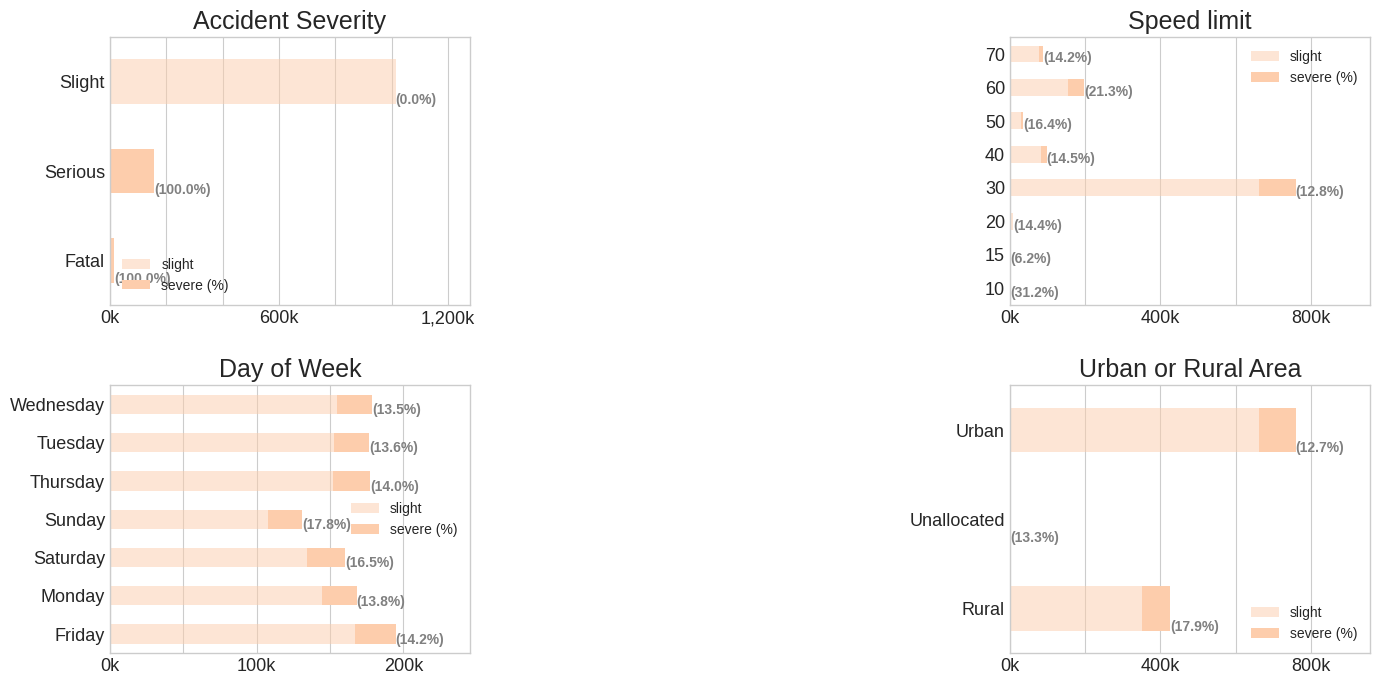

In [ ]:
plot_cat_cols('accidents', cat_cols1, fname='cat1_eda', bar_color=cmap(1))

## Weather, road surface and light conditions

Most accidents occur in normal weather, only Fog or High winds increase the proportion of severe accidents
Darkness significantly increase the probability of severe accidents
Bad Road surface conditions do not increase accident severity

Saving figure Figure(1400x800)


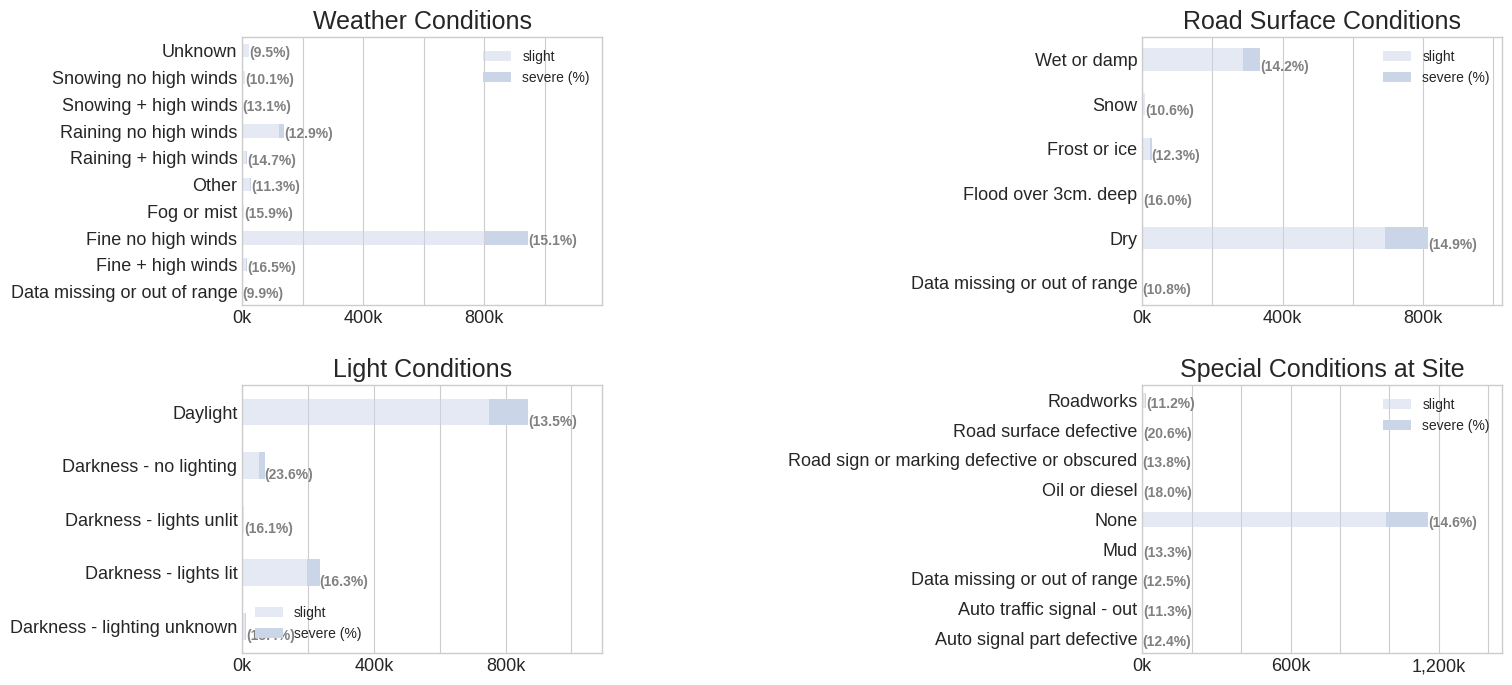

In [ ]:
plot_cat_cols('accidents', cat_cols2, fname='cat2_eda', bar_color=cmap(2))

## Road Types and Class

The majority of accidents occur in single carriage A class roads

Saving figure Figure(1400x800)


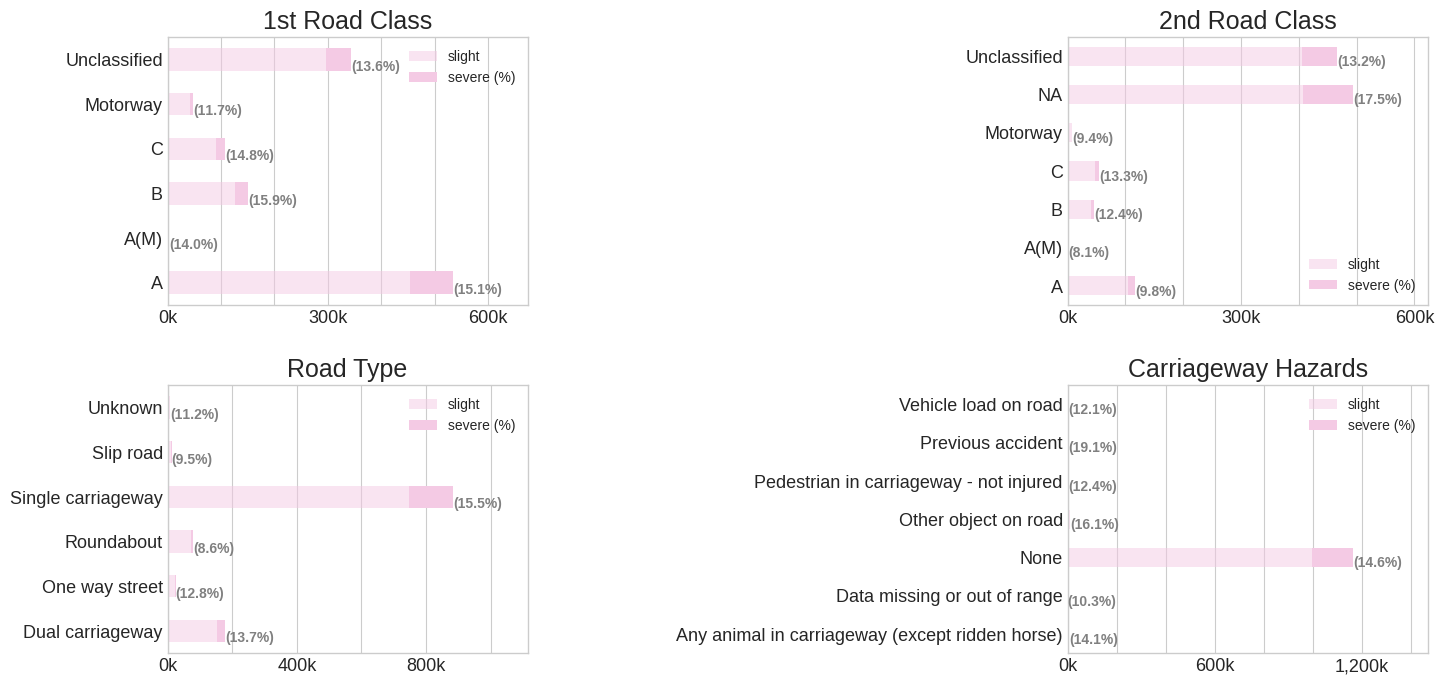

In [ ]:
plot_cat_cols('accidents', cat_cols3, fname='cat3_eda', bar_color=cmap(3))

## Junctions types

The majority of accidents occur away from a junction
Also the presence of a junction do not increase accident severity

Saving figure Figure(1400x800)


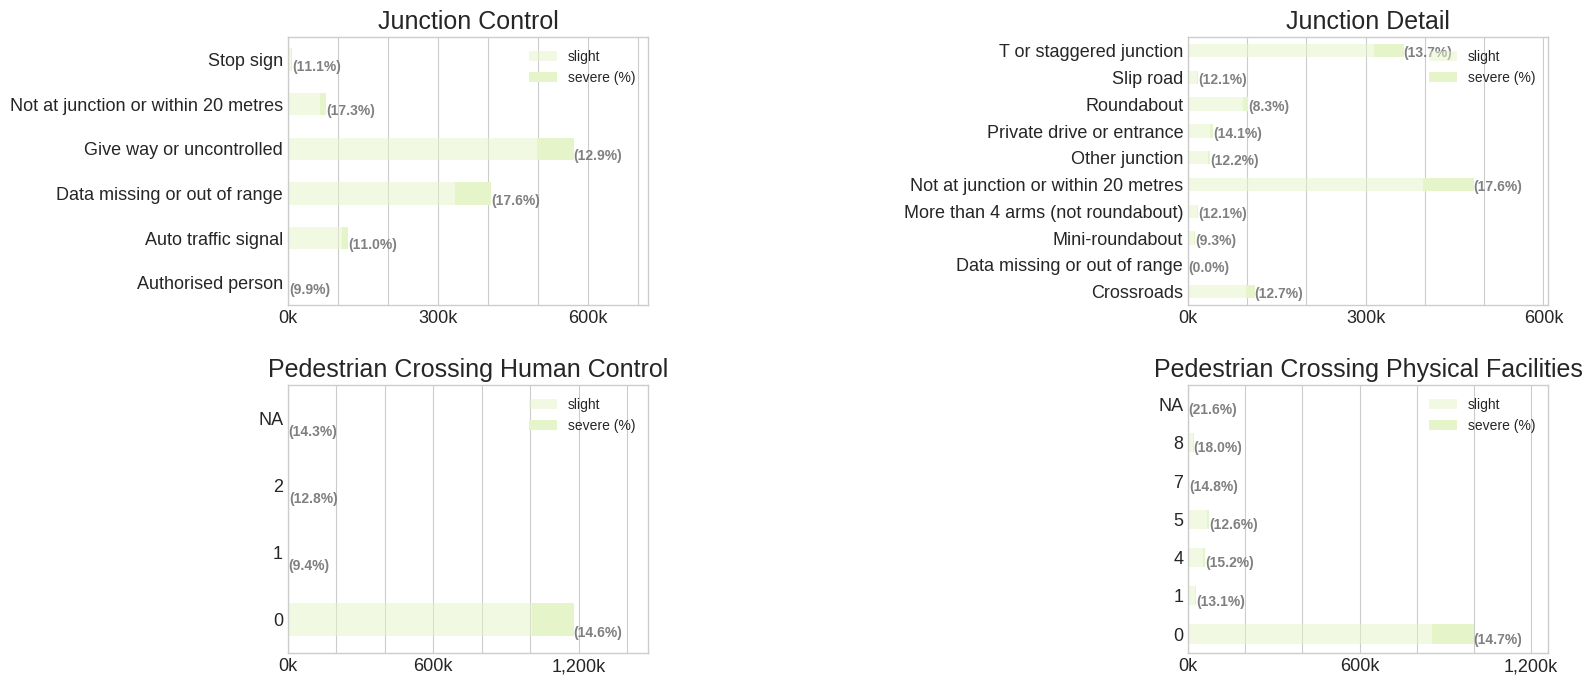

In [ ]:
plot_cat_cols('accidents', cat_cols4, fname='cat4_eda', bar_color=cmap(4))

Saving figure Figure(1400x400)


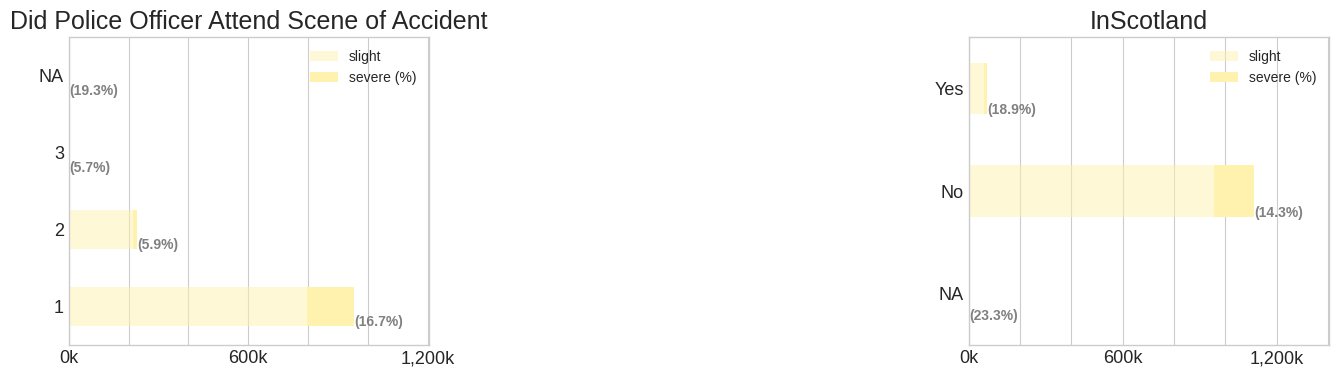

In [ ]:
plot_cat_cols('accidents', cat_cols5, fname='cat5_eda', bar_color=cmap(5))

## Display Ordinal Features

In [ ]:

#type conversions
ord_cols=["Hour",
           "Number_of_Casualties",
           "Number_of_Vehicles",
           "Year",]

def plot_ord_feature_old(df_view, col, ax=None, bar_color=cmap(6)):
    rdd_col = spark.sql("SELECT {}, COUNT({}) AS count FROM {} GROUP BY {}".format(col, col, df_view, col))
    df_plot = rdd_col.toPandas().sort_values(by=[col])
    ax = df_plot.plot(col, kind='bar', legend=False, ax=ax, fontsize=13, title=col.replace('_', ' '),
                      color=bar_color, edgecolor='black')
    #ax = plt.gca()
    ax.set_ylabel('')
    ax.set_alpha(0.8)
    ax.title.set_size(18)
    totals = []
    for i in ax.patches:
        totals.append(i.get_width())
    total = sum(totals)
    for patch in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
        patch.set_edgecolor("black")
        #ax.text(patch.get_width()*1.0, patch.get_y()*1.04, str(round((patch.get_width()/total)*100, 1))+'%',
        #        fontsize=10, color='grey', fontweight='bold')
    ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:0}".format(x)))
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}k".format(int(x/1000))))
    left, right = ax.get_xlim()  # return the current xlim
    ax.set_xlim((left, right*1.2))
    return rdd_col


def plot_ord_feature(df_view, col, ax=None, bar_color=cmap(6)):
    severe_col = "Accident_Severity"
    acc_type = "Slight"
    sql_query = '''
    SELECT
        {},
        COUNT(CASE WHEN {}  = '{}' THEN {} END) AS slight,
        COUNT(CASE WHEN {} != '{}' THEN {} END) AS severe
    FROM {} GROUP BY {}'''
    rdd_col = spark.sql(sql_query.format(col, severe_col, acc_type, col,severe_col, acc_type, col, df_view, col))
    df_plot = rdd_col.toPandas().dropna().sort_values(by=[col])
    clrmap = [(bar_color[0],bar_color[1],bar_color[2],bar_color[3]*0.5), bar_color]
    ax = df_plot.plot(col, kind='bar', ax=ax, fontsize=13, title=col.replace('_', ' '),
                      color=clrmap, stacked=True)
    #ax = plt.gca()
    ax.set_ylabel('')
    ax.set_alpha(0.8)
    ax.xaxis.grid(False)
    ax.set_xticklabels(df_plot[col])
    ax.title.set_size(18)
    for idx, label in enumerate(list(df_plot.index)):
        total = df_plot.loc[label]['slight']+df_plot.loc[label]['severe']
        value = "({}%)".format(np.round(100*df_plot.loc[label]['severe']/(total),decimals=1))
        ax.annotate(value, (idx, total), xytext=(0, 0), textcoords='offset points',
                   fontsize=10, color='grey', fontweight='bold', rotation=90, va ='bottom')

    #ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:0}".format(x)))
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}k".format(int(x/1000))))
    left, right = ax.get_ylim()  # return the current xlim
    ax.set_ylim((left, right*1.4))
    return rdd_col


def plot_ord_cols(df_view, cont_cols, fname='ord_eda',bar_color=cmap(6)):
    ncols = 2
    nrows = int(len(cont_cols)/ncols) + (1 if len(cont_cols)%ncols !=0 else 0)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*7, nrows*4))
    for n, col in enumerate(cont_cols):
        plot_ord_feature(df_view, col, ax=axes[int(n/ncols), n % ncols], bar_color=bar_color)
    for n in range(len(cont_cols), ncols*nrows):
        fig.delaxes(axes[int(n/ncols), n % ncols])
    plt.subplots_adjust(wspace =0.2, left=0, hspace=0.5)#bottom=0.1, right=0.8, top=0.9)
    if fname != '':
        save_fig(fig, fname,  tight_layout=False)

Saving figure Figure(700x500)


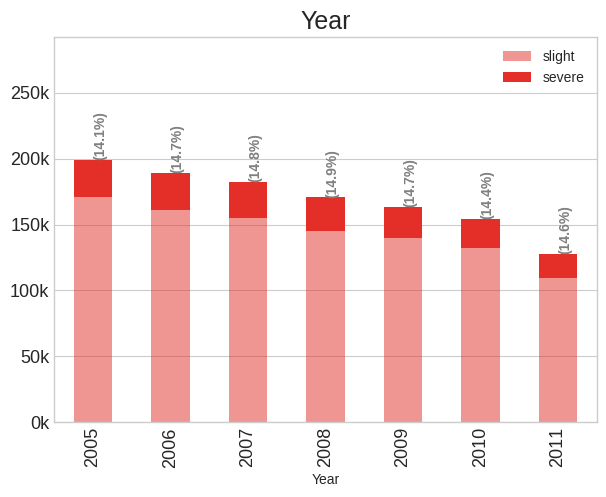

In [ ]:
fig, ax =plt.subplots(figsize=(7,5))
plot_ord_feature("accidents", 'Year', ax=ax, bar_color=plt.get_cmap('Reds')(170))
save_fig(fig, 'accidents_per_year',  tight_layout=False)